# Microsoft project
*Nathalie Dworaczek and Kevin Van Wallendael*

---

## Data exploration
---

In [1]:
# import the libraries needed for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import re,string,unicodedata
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path

In [14]:
# Import the data
df = pd.read_csv("train.csv")

In [15]:
# Explore the data 
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1


## Data transformation
---

In [16]:
# Removing the title
df.drop(columns = ["title"],axis=1,inplace=True)

In [17]:
# Transform the text column to string
df['text'] = df['text'].astype('str') 

In [18]:
# See the information for our current dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   author  18843 non-null  object
 2   text    20800 non-null  object
 3   label   20800 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 650.1+ KB


In [19]:
# Convert the text column to lowercase
df['text'] = df['text'].apply(lambda x: x.lower())


In [20]:
# Remove the punctuation within the text column
import string

def punct_removal(text):
    word_list = [char for char in text if char not in string.punctuation]
    clean_text = ''.join(word_list)
    return clean_text

df['text'] = df['text'].apply(punct_removal)

In [21]:
# Removing the stopwords within the text column
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

newStopWords = ['u','s', 't', 'isn', 'isn t', 'even', 'got', 'doesn t', 're', '\'', '-']
stop.extend(newStopWords)

df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
df = df.dropna()


In [23]:
df.head()

,id,author,text,label
0,0,Darrell Lucus,house dem aide didn’t see comey’s letter jason...,1
1,1,Daniel J. Flynn,ever get feeling life circles roundabout rathe...,0
2,2,Consortiumnews.com,truth might get fired october 29 2016 tension ...,1
3,3,Jessica Purkiss,videos 15 civilians killed single us airstrike...,1
4,4,Howard Portnoy,print iranian woman sentenced six years prison...,1


In [24]:
print(df.iloc[[142]])

      id               author  \
158  158  Katherine Rodriguez   

                                                  text  label  
158  secret service investigating burlesque dancer ...      0  


In [29]:
df = df.filter(['author', 'text', 'label'])
df.head()

,author,text,label
0,Darrell Lucus,house dem aide didn’t see comey’s letter jason...,1
1,Daniel J. Flynn,ever get feeling life circles roundabout rathe...,0
2,Consortiumnews.com,truth might get fired october 29 2016 tension ...,1
3,Jessica Purkiss,videos 15 civilians killed single us airstrike...,1
4,Howard Portnoy,print iranian woman sentenced six years prison...,1


## Visualizations
---

c:\Users\natha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

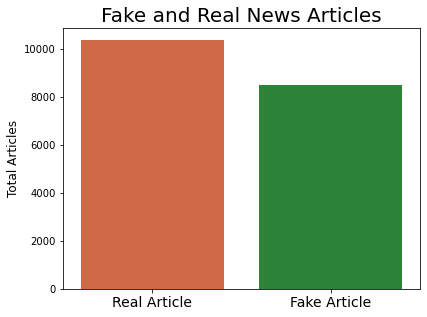

In [31]:
# Plot the amount of articles in each category
plt.figure(figsize=(6.4,4.8))

ax = sns.countplot(df.label, palette=['#e65e30',"#1f912c"])
plt.title('Fake and Real News Articles', fontsize=20)
plt.ylabel('Total Articles', fontsize=12)
plt.xlabel('')
plt.xticks([1, 0], ['Fake Article', 'Real Article'], fontsize=14)
ax.bar_label(ax.containers[0])
plt.show()

In [32]:
# Most frequent words counter   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

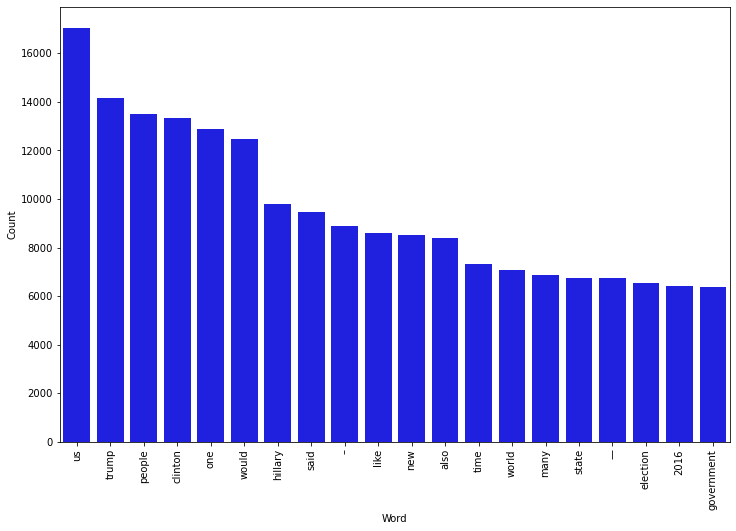

In [33]:
# Most frequent words in fake news
counter(df[df["label"] == 1], "text", 20)

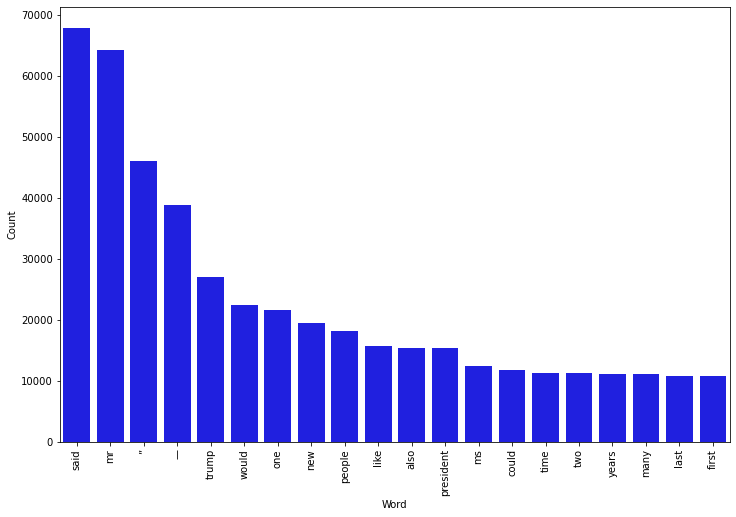

In [34]:
# Most frequent words in real news
counter(df[df["label"] == 0], "text", 20)

In [35]:
# Select real news articles for the wordcloud
data_real = df[df["label"] == 0]
real_words = ' '.join([text for text in data_real.text])

In [36]:
from PIL import Image, ImageDraw, ImageFont

width = 3030 
height = 1091 
message = "REAL"
f = r'C:\Windows\Fonts\GILSANUB.ttf'
font = ImageFont.truetype(font = f, size=800)

img = Image.new('RGB', (width, height), color='white')

imgDraw = ImageDraw.Draw(img)

textWidth, textHeight = imgDraw.textsize(message, font=font)
xText = (width - textWidth) / 2
yText = (height - textHeight) / 5

imgDraw.text((xText, yText), message, font=font, fill=(0, 0, 0), stroke_width=15,
          stroke_fill="black")

img.save('real_news.jpg')

(-0.5, 3029.5, 1090.5, -0.5)

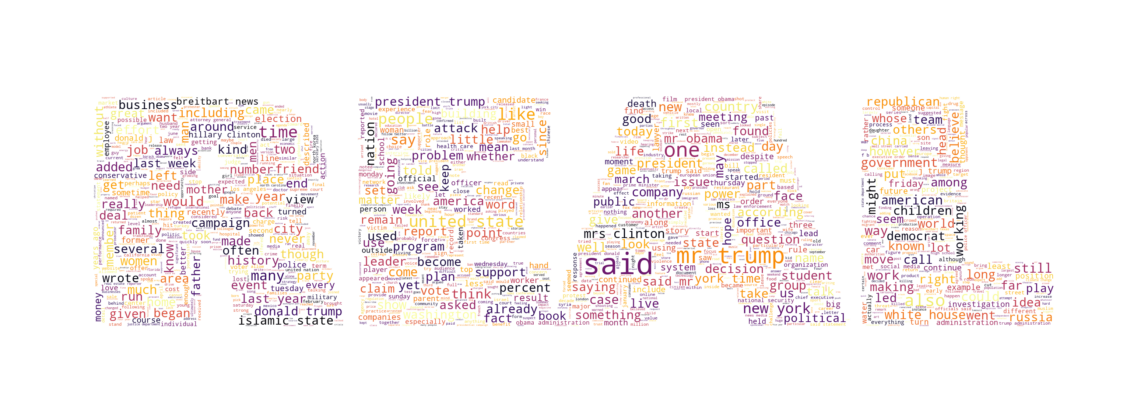

In [37]:
plt.figure(figsize = (20,20))

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# read the mask / color image taken from
coloring = np.array(Image.open(path.join(d, "real_news.jpg")))


wc = WordCloud(background_color="white", max_words=1500, mask=coloring, colormap='inferno',
               stopwords=stop, max_font_size=80)

# generate word cloud
wc.generate(real_words)

# create coloring from image
image_colors = ImageColorGenerator(coloring)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [38]:
# Select fake news articles for the wordcloud
data_fake = df[df["label"] == 1]
fake_words = ' '.join([text for text in data_fake.text])

In [39]:
# Create image mask "FAKE" to create a wordcloud
from PIL import Image, ImageDraw, ImageFont

width = 3030 
height = 1091 
message = "FAKE"
f = r'C:\Windows\Fonts\GILSANUB.ttf'
font = ImageFont.truetype(font = f, size=800)

img = Image.new('RGB', (width, height), color='white')

imgDraw = ImageDraw.Draw(img)

textWidth, textHeight = imgDraw.textsize(message, font=font)
xText = (width - textWidth) / 2
yText = (height - textHeight) / 5

imgDraw.text((xText, yText), message, font=font, fill=(0, 0, 0), stroke_width=15,
          stroke_fill="black")

img.save('fake_news.jpg')

(-0.5, 3029.5, 1090.5, -0.5)

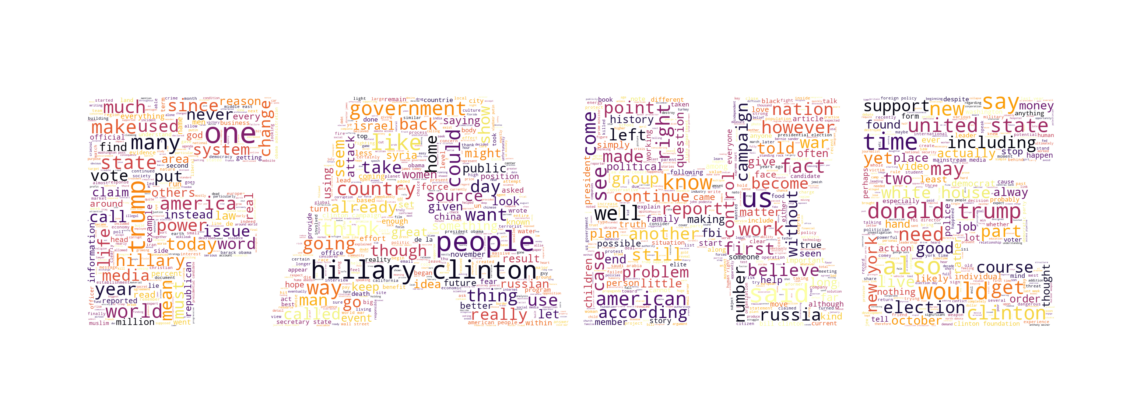

In [40]:
plt.figure(figsize = (20,20))

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# read the mask / color image taken from
coloring = np.array(Image.open(path.join(d, "fake_news.jpg")))


wc = WordCloud(background_color="white", max_words=1500, mask=coloring, colormap='inferno',
               stopwords=stop, max_font_size=80)

# generate word cloud
wc.generate(fake_words)

# create coloring from image
image_colors = ImageColorGenerator(coloring)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [41]:
#df.to_csv('df_wrangled.csv')

## ML Model
---

In [43]:
# Split the dataset for our model
X_train,X_test,y_train,y_test = train_test_split(df['text'], df.label, test_size=0.2, random_state=42)

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 90.74%


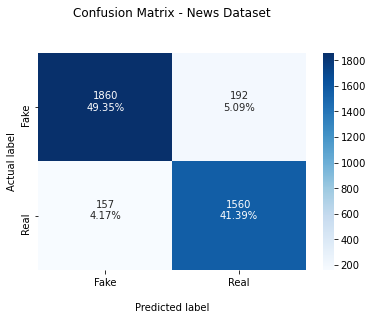

In [45]:
# Create a confusion matrix
cf_matrix = confusion_matrix(y_test, prediction)
m_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

m_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(m_counts,m_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix - News Dataset\n\n');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('Actual label');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Fake','Real'])
ax.yaxis.set_ticklabels(['Fake','Real'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Use self made dataset with fake- and real news articles to test the accuracy of our model
---

In [58]:
dfmade = pd.read_csv("new_data_set.csv")

In [61]:
dfmade.tail()

,Unnamed: 0,url,text,label
82,12,https://www.cnbc.com/2022/06/10/flu-hepatitis-...,Dowell | Moment | Getty Images\n\nThe Covid-19...,0
83,22,https://www.washingtonpost.com/world/2022/06/0...,Placeholder while article actions load\n\nWas ...,1
84,53,https://www.activistpost.com/2022/06/pfizer-ce...,By Matt Agorist\n\nThe world’s ruling elite wi...,1
85,39,https://www.eutimes.net/2022/05/this-misinform...,"Home » Breaking News, Injustice, Middle East, ...",1
86,47,https://21stcenturywire.com/2022/06/10/vernon-...,\n\nDr Vernon Coleman\n\n21st Century Wire\n\n...,1


In [63]:
# Clean the test dataset by doing the following steps:
dfmade = dfmade.filter(
    ["text", "label"]
)
dfmade['text'] = dfmade['text'].astype('str')  # Converting the text column to string
dfmade['text'] = dfmade['text'].apply(lambda x: x.lower()) # Converting the text column to lowercase
dfmade['text'] = dfmade['text'].apply(punct_removal) # Remove the punctuation within the column
dfmade['text'] = dfmade['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) # Removing the stopwords

In [64]:
prediction = model.predict(dfmade.text)
print("accuracy: {}%".format(round(accuracy_score(dfmade.label, prediction)*100,2)))

accuracy: 57.47%


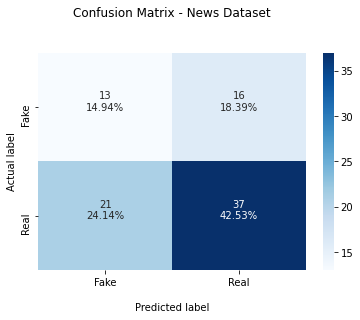

In [65]:
# Create a confusion matrix
cf_matrix = confusion_matrix(dfmade.label, prediction)
m_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

m_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(m_counts,m_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix - News Dataset\n\n');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('Actual label');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Fake','Real'])
ax.yaxis.set_ticklabels(['Fake','Real'])

## Display the visualization of the Confusion Matrix.
plt.show()